# **Example scenario-dependent Surplus Cost of Fossil Fuel Extraction | Use case 4**

**Authors:**  
[Romain Sacchi](mailto:romain.sacchi@psi.ch)  
[Alvaro Hahn Menacho](mailto:alvaro.hahn-menacho@psi.ch)


This notebook presents an example to build an edges-based LCA using a scenario-dependent Surplus Cost of Fossil Fuel Extraction method across three scenarios from REMIND v.3.5.  

This example is part of the following publication:

**Sacchi, R., Menacho, A. H., Seitfudem, G., Agez, M., Schlesinger, J., Koyamparambath, A., Saldivar, J. S., Loubet, P., & Bauer, C.** (2025). *Contextual LCIA Without the Overhead: An Exchange-based Framework for Flexible Impact Assessment.*  
International Journal of Life Cycle Assessment.

## Structure

1. [Import *edges* and set *bw2 project*](#sec_import_edges)
2. [Import hydrogen production, PEM, LCI](#sec_import_h2)
3. [Select *Functional Unit* and *method*](#sec_select_fu)
4. [Run edges based LCA](#sec_run_edges_lca)
5. [Export results](#sec_export_results)
6. [Plot results](#sec_plot_results)

<a id="sec_import_edges"></a>
# 1. Import edges and set bw2 project

In [2]:
from edges import EdgeLCIA, get_available_methods, setup_package_logging
import logging
import bw2data, bw2io

# we want the logger to log things into edges.log
#setup_package_logging(level=logging.INFO)
# if you want full debug:
setup_package_logging(level=logging.DEBUG)

/opt/homebrew/Caskroom/miniforge/base/envs/bw25/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


14:27:15+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


For our example, we activate a ``brighway`` project that contains ecoinvent 3.10 cut-off.

In [3]:
bw2data.projects.set_current("bw25_ei310")

<a id="sec_import_h2"></a>
# 2. Import hydrogen production, PEM, LCI

In [ ]:
if "h2_pem" in bw2data.databases:
    del bw2data.databases["h2_pem"]
lci = bw2io.ExcelImporter("lci-hydrogen-electrolysis-ei310.xlsx")
lci.apply_strategies()
lci.match_database(fields=["name", "reference product", "location"])
lci.match_database("ecoinvent-3.10-cutoff",fields=["name", "reference product", "location"])
lci.match_database("biosphere",fields=["name", "categories"])
lci.statistics()
lci.drop_unlinked(i_am_reckless=True)
if len(list(lci.unlinked)) == 0:
    lci.write_database()

# we assign manually classifications to activities
# since it is unclear how to do that in the Excel inventory file.

classifications = {
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from solar photovoltaic electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from onshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from geothermal electricity": ("CPC", "34210"),
    "electrolyzer production, 1MWe, PEM, Stack": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer stack, 1MWe, PEM": ("CPC", "3830"),
    "electrolyzer production, 1MWe, PEM, Balance of Plant": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer balance of plant, 1MWe, PEM": ("CPC", "3830"),
    "platinum group metal, extraction and refinery operations": ("CPC", "2420"),
    "deionized water production, via reverse osmosis, from brackish water": ("CPC", "34210")
}
for ds in bw2data.Database("h2_pem"):
    if ds["name"] in classifications:
        ds["classifications"] = [classifications[ds["name"]]]
        ds.save()

<a id="sec_select_fu"></a>
# 3. Select Functional Unit and method

### 3.1. Select FU
We select the activity to run the LCA for. In our case, it is the production of 1 kg of hydrogen, using a PEM electrolyzer, powered with offshore wind power, in France.

In [5]:
act = [a for a in bw2data.Database("h2_pem") if a["name"] == "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity"][0]
act

'hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity' (kilogram, FR, None)

### 3.2. Select method

We select the Surplus Cost Production LCIA method.

In [ ]:
method = ('SCP', '1.0')

<a id="sec_run_edges_lca"></a>
# 4. Run edges-based LCA

In [23]:
lcia = EdgeLCIA(
    demand={act: 1},
    method=method,
)

lcia.lci()
lcia.map_exchanges()

/opt/homebrew/Caskroom/miniforge/base/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)
Mapping exchanges: 100%|██████████████████████████| 5/5 [00:00<00:00, 96.99it/s]


In [24]:
lcia.statistics()

+----------------------+--------------------------------------------+
|       Activity       | hydrogen production, gaseous, 30 bar, from |
|                      |    PEM electrolysis, from offshore wind    |
|                      |                electricity                 |
|     Method name      |               ('SCP', '1.0')               |
|         Unit         |                    USD                     |
|      Data file       |                  SCP_1.0                   |
|    CFs in method     |                     5                      |
|       CFs used       |                     4                      |
|   Unique CFs used    |                     3                      |
|  Exc. characterized  |                    509                     |
| Exc. uncharacterized |                   335463                   |
+----------------------+--------------------------------------------+


<a id="sec_export_results"></a>
# 5. Export results

We will evaluate the CFs while iterating through the scenarios and accessing scenario-specific parameters.

In [25]:
import pandas as pd
import itertools

In [26]:
scenarios = list(lcia.parameters.keys())

In [27]:
scenarios

['SSP1-PkBudg650',
 'SSP2-NPi',
 'SSP3-PkBudg1000',
 'SSP2-PkBudg650',
 'SSP2-PkBudg1000',
 'SSP2-rollBack',
 'SSP3-rollBack',
 'SSP1-NPi',
 'SSP1-PkBudg1000',
 'SSP3-NPi',
 'SSP1-NDC',
 'SSP3-NDC',
 'SSP2-NDC']

In [28]:
# let's reduce the number of scenarios for clarity in the plot
scenarios = [
    'SSP1-PkBudg650', # ambitious
    'SSP2-NPi', # business-as-usual
    'SSP3-rollBack', # right out bad!
]

In [29]:
years = list(lcia.parameters[scenarios[0]]["P_COAL"].keys())

In [30]:
years

['2010',
 '2015',
 '2020',
 '2025',
 '2030',
 '2035',
 '2040',
 '2045',
 '2050',
 '2055',
 '2060',
 '2070',
 '2080',
 '2090',
 '2100',
 '2110',
 '2130',
 '2150']

In [31]:
results = []
for scenario in scenarios:
    for year in years:
        # we evalute the CFs and pass the scenario name and year
        lcia.evaluate_cfs(scenario=scenario, scenario_idx=year)
        lcia.lcia()
        
        results.append({
            "Scenario": scenario,
            "Year": int(year),
            "Impact": lcia.score
        })
        
impact_df = pd.DataFrame(results)
impact_df = impact_df.loc[
    (impact_df["Year"]<=2100)
    &(impact_df["Year"]>=2025)
]

In [32]:
impact_df

,Scenario,Year,Impact
3,SSP1-PkBudg650,2025,0.006291
4,SSP1-PkBudg650,2030,0.005308
5,SSP1-PkBudg650,2035,0.002624
6,SSP1-PkBudg650,2040,0.001332
7,SSP1-PkBudg650,2045,0.000658
8,SSP1-PkBudg650,2050,0.000409
9,SSP1-PkBudg650,2055,0.000332
10,SSP1-PkBudg650,2060,0.000368
11,SSP1-PkBudg650,2070,0.000314
12,SSP1-PkBudg650,2080,0.000276


<a id="sec_plot_results"></a>
# 6. Plot results

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [34]:
def get_ssp(scenario):
    return scenario.split("-")[0]

def get_style(scenario):
    for suffix, style in style_by_suffix.items():
        if scenario.endswith(suffix):
            return style
    return '-'  # default

style_by_suffix = {
    "NDC": "-",
    "NPi": "--",
    "rollBack": "-.",
    "PkBudg1000": ":",
    "PkBudg650": (0, (1, 1))  # dotted
}

/var/folders/cn/pys1j9rn0y7djkhv3hfdtrs00000gn/T/ipykernel_41743/865686922.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


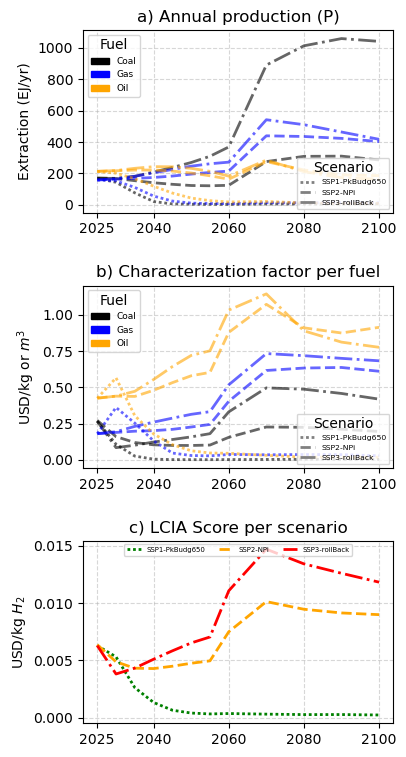

In [35]:
# Load the LCIA JSON file
with open("../../edges/data/SCP_1.0.json", "r") as f:
    lcia_data = json.load(f)

# Convert the JSON data into a flat DataFrame
records = []
for scenario, values in lcia_data["scenarios"].items():
    if scenario in scenarios:
        for fuel in ["COAL", "GAS", "OIL"]:
            P = values.get(f"P_{fuel}", {})
            MCI = values.get(f"MCI_{fuel}", {})
            for year in sorted(set(P).intersection(MCI)):
                d_val = values["d"].get(year, 0)
                records.append({
                    "Scenario": scenario,
                    "Year": int(year),
                    "Fuel": fuel.capitalize(),
                    "P": P[year],  # EJ/year
                    "MCI": MCI[year],  # USD/GJ²
                    "d": d_val  # discount rate
                })

df = pd.DataFrame(records)

# Calculate CF in USD/GJ
df["CF [USD/GJ]"] = (df["MCI"] * df["P"]) / (5 * (1 + df["d"]))

# Convert CF from USD/GJ to USD/kg or m³
energy_content = {"Coal": 24, "Oil": 42, "Gas": 35}  # MJ/kg or MJ/m³
df["CF [USD/kg or m3]"] = df.apply(
    lambda row: row["CF [USD/GJ]"] / (energy_content[row["Fuel"]] / 1000), axis=1
)


from matplotlib.lines import Line2D

# Unique scenario styles from your data
unique_scenarios = sorted(df["Scenario"].unique(), key=lambda x: (get_ssp(x), x))

# Create custom handles for scenario line styles
scenario_handles = []
for scen in unique_scenarios:
    style = get_style(scen)
    color = "gray"  # Neutral color to indicate line style only
    scenario_handles.append(
        Line2D([0], [0], color=color, linestyle=style, label=scen, linewidth=2)
    )

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(4, 9), sharex=False, gridspec_kw={"hspace": 0.4})
fuel_colors = {"Coal": "black", "Gas": "blue", "Oil": "orange"}

# Top plot: MCI and P (log scale)
# Top plot: MCI and P (log scale)
for fuel in ["Coal", "Gas", "Oil"]:
    sub_df = df[df["Fuel"] == fuel]
    for scenario in sub_df["Scenario"].unique():
        scenario_df = sub_df[
            (sub_df["Scenario"] == scenario)
            & (sub_df["Year"] <= 2100)
            & (sub_df["Year"] >= 2025)
        ]
        linestyle = get_style(scenario)  # <-- Add this line
        axs[0].plot(
            scenario_df["Year"],
            scenario_df["P"],
            color=fuel_colors[fuel],
            linestyle=linestyle,  # <-- Apply line style
            alpha=0.6,
            linewidth=2,
        )

axs[0].set_ylabel("Extraction (EJ/yr)")
axs[0].set_title("a) Annual production (P)")
axs[0].grid(True, linestyle="--", alpha=0.5)
#axs[0].set_yscale('log')
axs[0].set_xticks([2025, 2040, 2060, 2080, 2100])


# After plotting all lines in axs[0], add:
legend_handles = [
    Patch(color="black", label="Coal"),
    Patch(color="blue", label="Gas"),
    Patch(color="orange", label="Oil")
]
fuel_legend = axs[0].legend(handles=legend_handles, title="Fuel", loc="upper left", fontsize=6.5)

axs[0].add_artist(fuel_legend)  # Add fuel legend first

axs[0].legend(
    handles=scenario_handles,
    title="Scenario",
    loc="lower right",
    fontsize=5.5,
    frameon=True
)

# Middle plot: CFs (USD/unit)
# Middle plot: CFs (USD/unit)
for fuel in ["Coal", "Gas", "Oil"]:
    sub_df = df[df["Fuel"] == fuel]
    for scenario in sub_df["Scenario"].unique():
        scenario_df = sub_df[
            (sub_df["Scenario"] == scenario)
            & (sub_df["Year"] <= 2100)
            & (sub_df["Year"] >= 2025)
        ]
        linestyle = get_style(scenario)  # <-- Add this line
        axs[1].plot(
            scenario_df["Year"],
            scenario_df["CF [USD/kg or m3]"],
            color=fuel_colors[fuel],
            linestyle=linestyle,  # <-- Apply line style
            alpha=0.6,
            linewidth=2,
        )

axs[1].set_ylabel("USD/kg or $m^3$")
axs[1].set_title("b) Characterization factor per fuel")
axs[1].grid(True, linestyle="--", alpha=0.5)
axs[1].set_xticks([2025, 2040, 2060, 2080, 2100])

fuel_legend = axs[1].legend(handles=legend_handles, title="Fuel", loc="upper left", fontsize=6.5)

axs[1].add_artist(fuel_legend)

axs[1].legend(
    handles=scenario_handles,
    title="Scenario",
    loc="lower right",
    fontsize=5.5,
    frameon=True
)

# Bottom plot: Actual LCA results
# Assign colors to SSP groups
ssp_colors = {
    "SSP1": "green",
    "SSP2": "orange",
    "SSP3": "red"
}

# Bottom plot: LCA results with SSP-colored lines and distinct line styles

handles_dict = {}
for scenario in sorted(impact_df["Scenario"].unique(), key=lambda x: (get_ssp(x), x)):
    scenario_data = impact_df[impact_df["Scenario"] == scenario]
    color = ssp_colors.get(get_ssp(scenario), "gray")
    style = get_style(scenario)

    line, = axs[2].plot(
        scenario_data["Year"],
        scenario_data["Impact"],
        label=scenario,
        color=color,
        linestyle=style,
        linewidth=2,
    )
    handles_dict[scenario] = line
axs[2].set_title("c) LCIA Score per scenario")
axs[2].set_ylabel("USD/kg $H_2$")
axs[2].grid(True, linestyle="--", alpha=0.5)
axs[2].set_xticks([2025, 2040, 2060, 2080, 2100])

ordered_scenarios = sorted(handles_dict.keys(), key=lambda x: (get_ssp(x), x))
ordered_handles = [handles_dict[scen] for scen in ordered_scenarios]

axs[2].legend(
    ordered_handles,
    ordered_scenarios,
    #title="Scenario",
    loc="lower center",
    bbox_to_anchor=(0.5, 0.9),
    fontsize=5,
    ncol=3,
    frameon=True
)

plt.tight_layout()
plt.savefig("figure_4.png", bbox_inches="tight", dpi=200)
plt.show()